In [34]:
# Cell 1: Enhanced Data Preprocessing and Quality Check
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load datasets
augments_df = pd.read_csv('TFT-augments.csv')
matches_df = pd.read_csv('my_tft_dataset.csv')

# Data Quality Assessment
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)
print(f"\nAugments Dataset Shape: {augments_df.shape}")
print(f"Matches Dataset Shape: {matches_df.shape}")
print(f"\nMissing Values in Augments:")
print(augments_df.isnull().sum())
print(f"\nMissing Values in Matches:")
print(matches_df.isnull().sum())
print(f"\nData Types:")
print(matches_df.dtypes)

DATA QUALITY ASSESSMENT

Augments Dataset Shape: (268, 8)
Matches Dataset Shape: (800, 25)

Missing Values in Augments:
Augment Name           0
Average Placement      0
Games Played           0
At 2-1               120
At 3-2                76
At 4-2               101
Top 4                  0
Win Rate               0
dtype: int64

Missing Values in Matches:
match_id                     0
game_datetime                0
game_length                  0
game_version                 0
tft_set_number               0
tft_set_core_name            0
queue_id                     0
puuid                        0
placement                    0
level                        0
gold_left                    0
last_round                   0
players_eliminated           0
time_eliminated              0
total_damage_to_players      0
augment_1                  800
augment_2                  800
augment_3                  800
augments_all               800
num_augments                 0
traits             

ADVANCED AUGMENT STATISTICAL ANALYSIS

Top Augments with Statistical Confidence Intervals:
            Augment  Win Rate  Games  Avg Placement  Wilson Lower  Wilson Upper  CI Width
Ixtal Expeditionist      0.27    253           4.75      0.219035      0.327845  0.108809
          Max Build      0.25    500           4.12      0.214048      0.289764  0.075717
          Ascension      0.21    184           4.03      0.157381      0.274480  0.117099
           Firesale      0.20    281           4.24      0.157417      0.250675  0.093258
    The Trait Tree+      0.19    188           4.36      0.140348      0.252068  0.111720
      Tiniest Titan      0.19    172           4.04      0.138394      0.255152  0.116758
         Invested++      0.19    134           4.45      0.132581      0.264699  0.132118
       Urf's Gambit      0.19    115           4.30      0.128780      0.271262  0.142482
    Spreading Roots      0.18    339           4.33      0.142760      0.224411  0.081651
   Spread

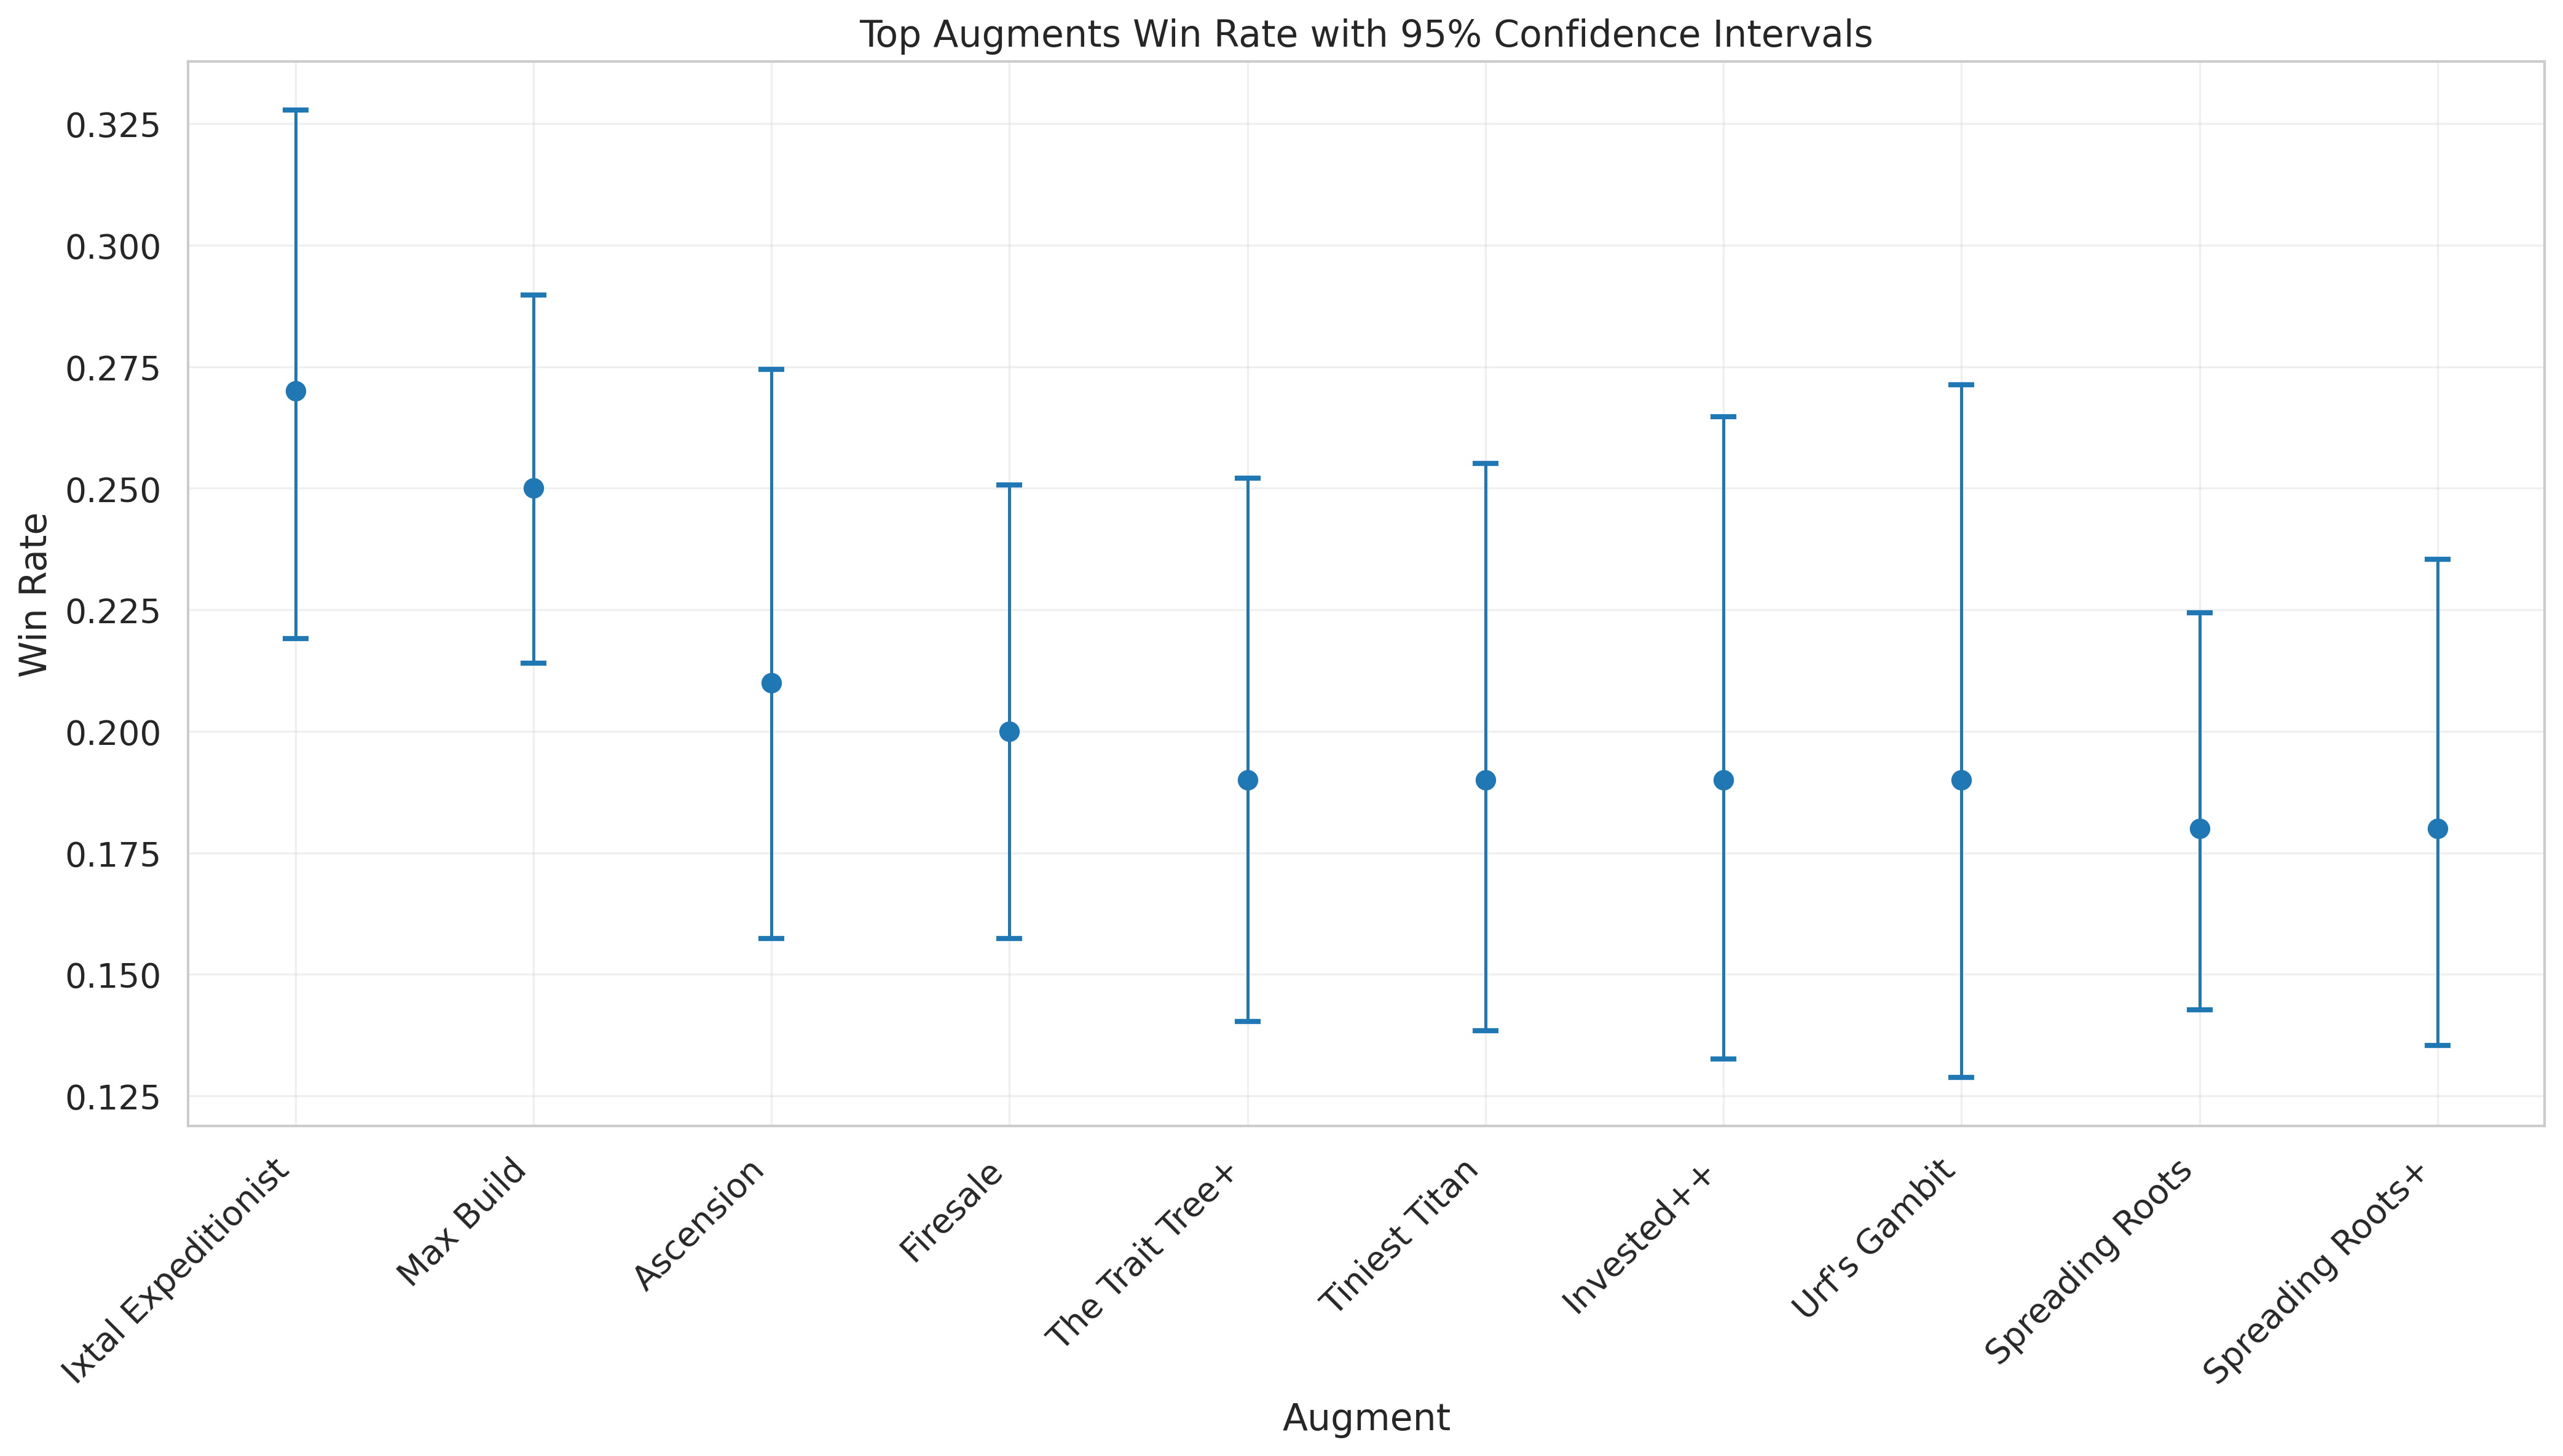

In [35]:
# Cell 2: Advanced Statistical Analysis - Augment Performance Metrics
print("="*60)
print("ADVANCED AUGMENT STATISTICAL ANALYSIS")
print("="*60)

# Calculate confidence intervals for top augments
def calculate_ci(data, confidence=0.95):
    """Calculate confidence interval for mean"""
    n = len(data)
    if n < 2:
        return 0, 0
    mean = np.mean(data)
    se = stats.sem(data)
    margin = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - margin, mean + margin

# Analyze top performing augments with statistical rigor
top_augments_analysis = []
for _, row in top_augments.head(10).iterrows():
    augment_name = row['Augment Name']
    win_rate = row['Win Rate']
    games_played = row['Games Played']
    avg_placement = row['Average Placement']

    # Calculate Wilson score for more accurate win rate estimation
    z = 1.96  # 95% confidence
    phat = win_rate
    n = games_played
    denominator = 1 + z**2/n
    centre = (phat + z**2/(2*n)) / denominator
    wilson_ci = z * np.sqrt((phat*(1-phat) + z**2/(4*n))/n) / denominator

    top_augments_analysis.append({
        'Augment': augment_name,
        'Win Rate': win_rate,
        'Games': games_played,
        'Avg Placement': avg_placement,
        'Wilson Lower': centre - wilson_ci,
        'Wilson Upper': centre + wilson_ci,
        'CI Width': 2 * wilson_ci
    })

stats_df = pd.DataFrame(top_augments_analysis)
print("\nTop Augments with Statistical Confidence Intervals:")
print(stats_df.to_string(index=False))

# Visualization of confidence intervals
plt.figure(figsize=(14, 8))
augments = stats_df['Augment'].values
win_rates = stats_df['Win Rate'].values
lower_bounds = stats_df['Wilson Lower'].values
upper_bounds = stats_df['Wilson Upper'].values

plt.errorbar(range(len(augments)), win_rates,
             yerr=[win_rates - lower_bounds, upper_bounds - win_rates],
             fmt='o', capsize=5, capthick=2, markersize=8)
plt.xticks(range(len(augments)), augments, rotation=45, ha='right')
plt.ylabel('Win Rate')
plt.xlabel('Augment')
plt.title('Top Augments Win Rate with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('augment_confidence_intervals.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: augment_confidence_intervals.png")

In [36]:
# Cell 3: Player Performance Pattern Analysis
print("="*60)
print("PLAYER PERFORMANCE PATTERN ANALYSIS")
print("="*60)

your_puuid = matches_df['puuid'].mode()[0]
your_games = matches_df[matches_df['puuid'] == your_puuid].copy()

# Extract traits function
def extract_traits(trait_string):
    if pd.isna(trait_string):
        return []
    return re.findall(r'TFT\d+_(\w+)\(\d+\)', str(trait_string))

your_games['trait_list'] = your_games['traits'].apply(extract_traits)

# Time-based performance analysis
if 'game_datetime' in your_games.columns:
    your_games['game_datetime'] = pd.to_datetime(your_games['game_datetime'])
    your_games = your_games.sort_values('game_datetime')
    your_games['game_number'] = range(1, len(your_games) + 1)
else:
    your_games = your_games.reset_index(drop=True)
    your_games['game_number'] = range(1, len(your_games) + 1)

# Calculate multiple rolling windows for trend analysis
windows = [5, 10, 20]
for window in windows:
    your_games[f'rolling_avg_{window}'] = your_games['placement'].rolling(
        window=window, min_periods=1).mean()
    your_games[f'rolling_winrate_{window}'] = your_games['win'].rolling(
        window=window, min_periods=1).mean()

# Identify performance phases
def identify_phase(placement):
    if placement <= 3:
        return 'Strong'
    elif placement <= 5:
        return 'Average'
    else:
        return 'Weak'

your_games['performance_phase'] = your_games['placement'].apply(identify_phase)

# Phase distribution
phase_dist = your_games['performance_phase'].value_counts()
print("\nPerformance Phase Distribution:")
print(phase_dist)
print(f"\nPhase Percentages:")
for phase, count in phase_dist.items():
    print(f"  {phase}: {count/len(your_games)*100:.1f}%")

# Statistical summary by phase
print("\nStatistical Summary by Performance Phase:")
phase_summary = your_games.groupby('performance_phase').agg({
    'placement': ['mean', 'std', 'count'],
    'win': 'sum',
    'top_4': 'sum'
}).round(2)
print(phase_summary)

PLAYER PERFORMANCE PATTERN ANALYSIS

Performance Phase Distribution:
performance_phase
Weak       41
Strong     40
Average    19
Name: count, dtype: int64

Phase Percentages:
  Weak: 41.0%
  Strong: 40.0%
  Average: 19.0%

Statistical Summary by Performance Phase:
                  placement             win top_4
                       mean   std count sum   sum
performance_phase                                
Average                4.68  0.48    19   0     6
Strong                 1.70  0.85    40  22    40
Weak                   6.88  0.78    41   0     0


TRAIT SYNERGY ANALYSIS

Trait Co-occurrence Matrix (Raw Counts):
               Juggernaut  Brawler  Defender  Piltover  Sorcerer  \
Juggernaut              0       25        18        13        25   
Brawler                25        0         0         0        12   
Defender               18        0         0        25        18   
Piltover               13        0        25         0        13   
Sorcerer               25       12        18        13         0   
ShyvanaUnique          27       13        11        12        17   
Targon                 13        3        18        18        14   
Warden                  6        6        12        14         4   
Harvester              13        8         7        10         6   
Magus                   7        1        14        18         4   

               ShyvanaUnique  Targon  Warden  Harvester  Magus  
Juggernaut                27      13       6         13      7  
Brawler                   13       3       6          8 

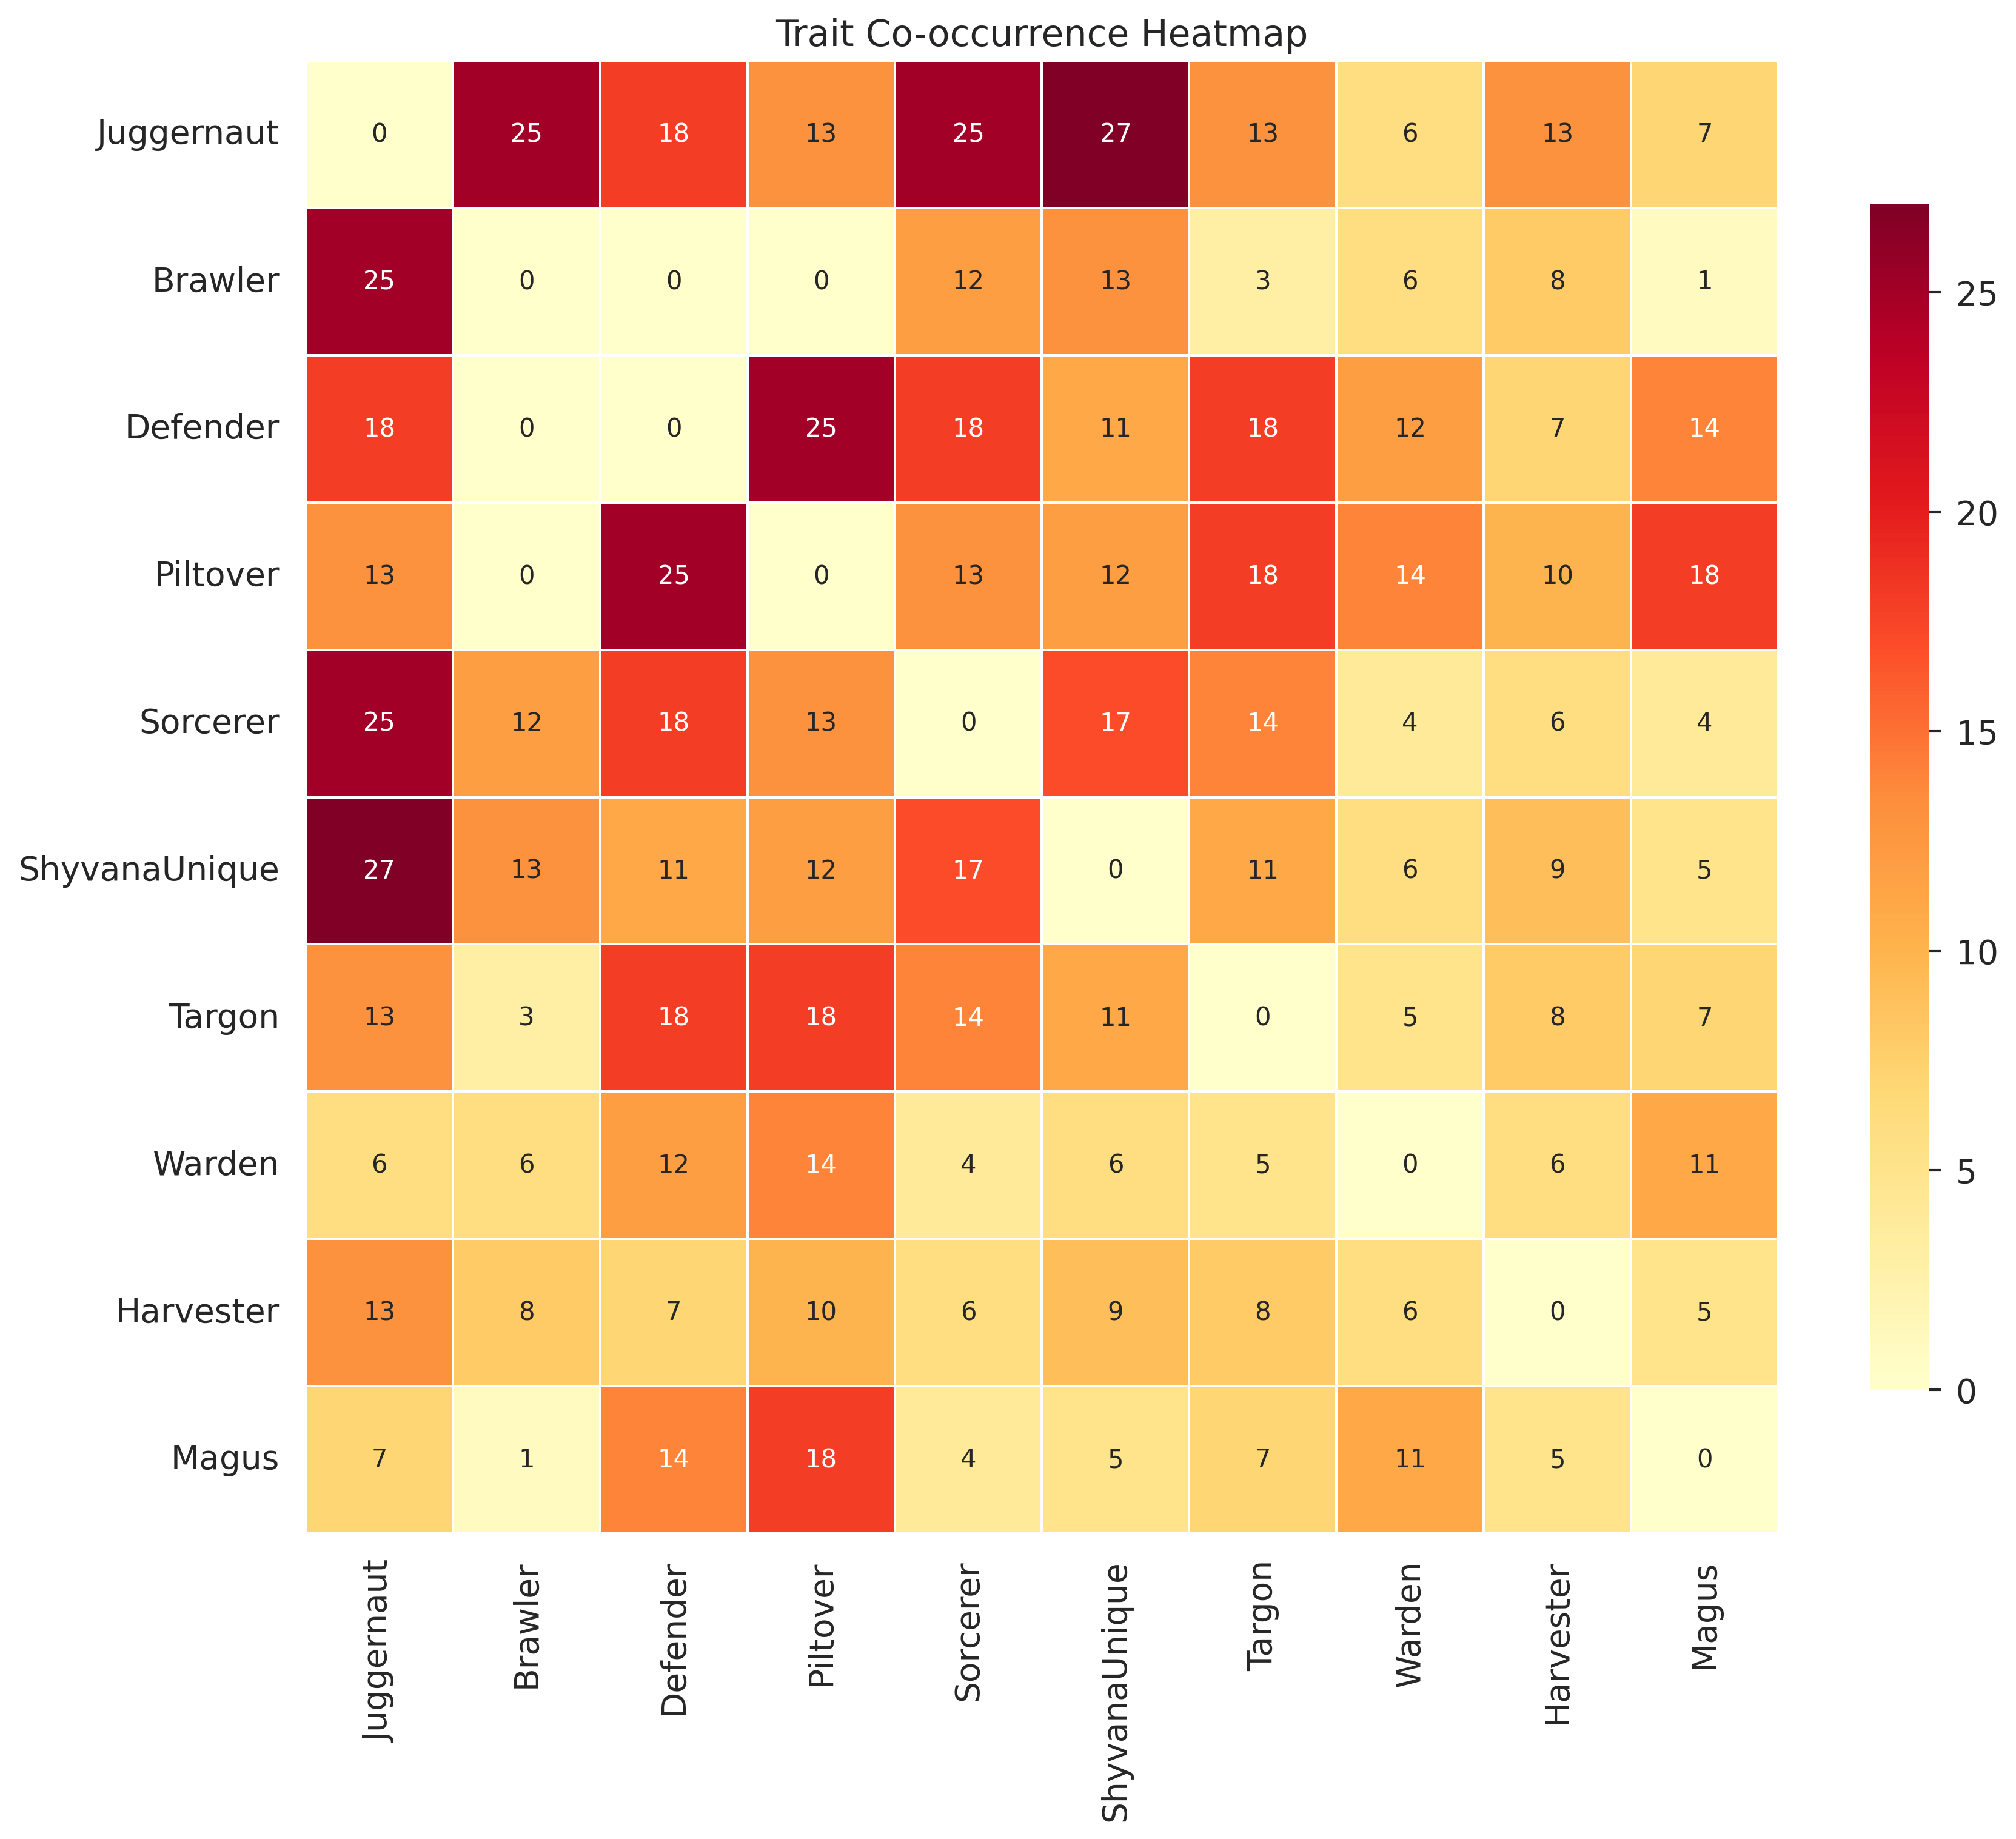

In [29]:
# Cell 4: Trait Synergy and Co-occurrence Analysis
print("="*60)
print("TRAIT SYNERGY ANALYSIS")
print("="*60)

from itertools import combinations

# Build trait co-occurrence matrix
all_traits = [trait for sublist in your_games['trait_list'] for trait in sublist]
trait_counts = Counter(all_traits)
top_10_traits = [t[0] for t in trait_counts.most_common(10)]

# Initialize co-occurrence matrix
cooccurrence_matrix = pd.DataFrame(0, index=top_10_traits, columns=top_10_traits)

# Calculate co-occurrences
for trait_list in your_games['trait_list']:
    for t1, t2 in combinations(trait_list, 2):
        if t1 in top_10_traits and t2 in top_10_traits:
            cooccurrence_matrix.loc[t1, t2] += 1
            cooccurrence_matrix.loc[t2, t1] += 1

print("\nTrait Co-occurrence Matrix (Raw Counts):")
print(cooccurrence_matrix)

# Visualize co-occurrence matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='YlOrRd',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Trait Co-occurrence Heatmap')
plt.tight_layout()
plt.savefig('trait_cooccurrence.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: trait_cooccurrence.png")

# Calculate trait synergy scores (average placement when traits appear together)
synergy_scores = {}
for t1, t2 in combinations(top_10_traits, 2):
    games_with_both = your_games[your_games['trait_list'].apply(
        lambda x: t1 in x and t2 in x)]
    if len(games_with_both) >= 3:  # Minimum sample size
        avg_placement = games_with_both['placement'].mean()
        synergy_scores[f"{t1} + {t2}"] = {
            'avg_placement': avg_placement,
            'games': len(games_with_both),
            'win_rate': games_with_both['win'].mean()
        }

# Sort and display top synergies
sorted_synergies = sorted(synergy_scores.items(),
                          key=lambda x: x[1]['avg_placement'])

print("\n🔥 Top 5 Trait Synergies (Best Average Placement):")
for combo, stats in sorted_synergies[:5]:
    print(f"  {combo}: Avg {stats['avg_placement']:.2f} "
          f"(WR: {stats['win_rate']*100:.1f}%, Games: {stats['games']})")

print("\n⚠️ Bottom 5 Trait Synergies (Worst Average Placement):")
for combo, stats in sorted_synergies[-5:]:
    print(f"  {combo}: Avg {stats['avg_placement']:.2f} "
          f"(WR: {stats['win_rate']*100:.1f}%, Games: {stats['games']})")

PREDICTIVE PERFORMANCE INDICATORS

Features Most Correlated with Better Placement (Lower = Better):
top_4               -0.873371
win                 -0.725908
has_ShyvanaUnique   -0.158454
has_Sorcerer        -0.046652
has_Harvester       -0.035923
has_Warden           0.000423
has_Magus            0.005257
has_Juggernaut       0.027008
has_Brawler          0.030179
has_Piltover         0.063860
Name: placement, dtype: float64

Features Most Correlated with Worse Placement:
has_Harvester    -0.035923
has_Warden        0.000423
has_Magus         0.005257
has_Juggernaut    0.027008
has_Brawler       0.030179
has_Piltover      0.063860
has_Defender      0.100301
game_length       0.121031
has_Targon        0.280656
placement         1.000000
Name: placement, dtype: float64

✅ Saved: correlation_matrix_detailed.png

STATISTICAL SIGNIFICANCE TESTS

Trait Impact Significance Tests:
        Trait  With (n)  Without (n)  Avg With  Avg Without    Effect  P-value Significant
       Targon      

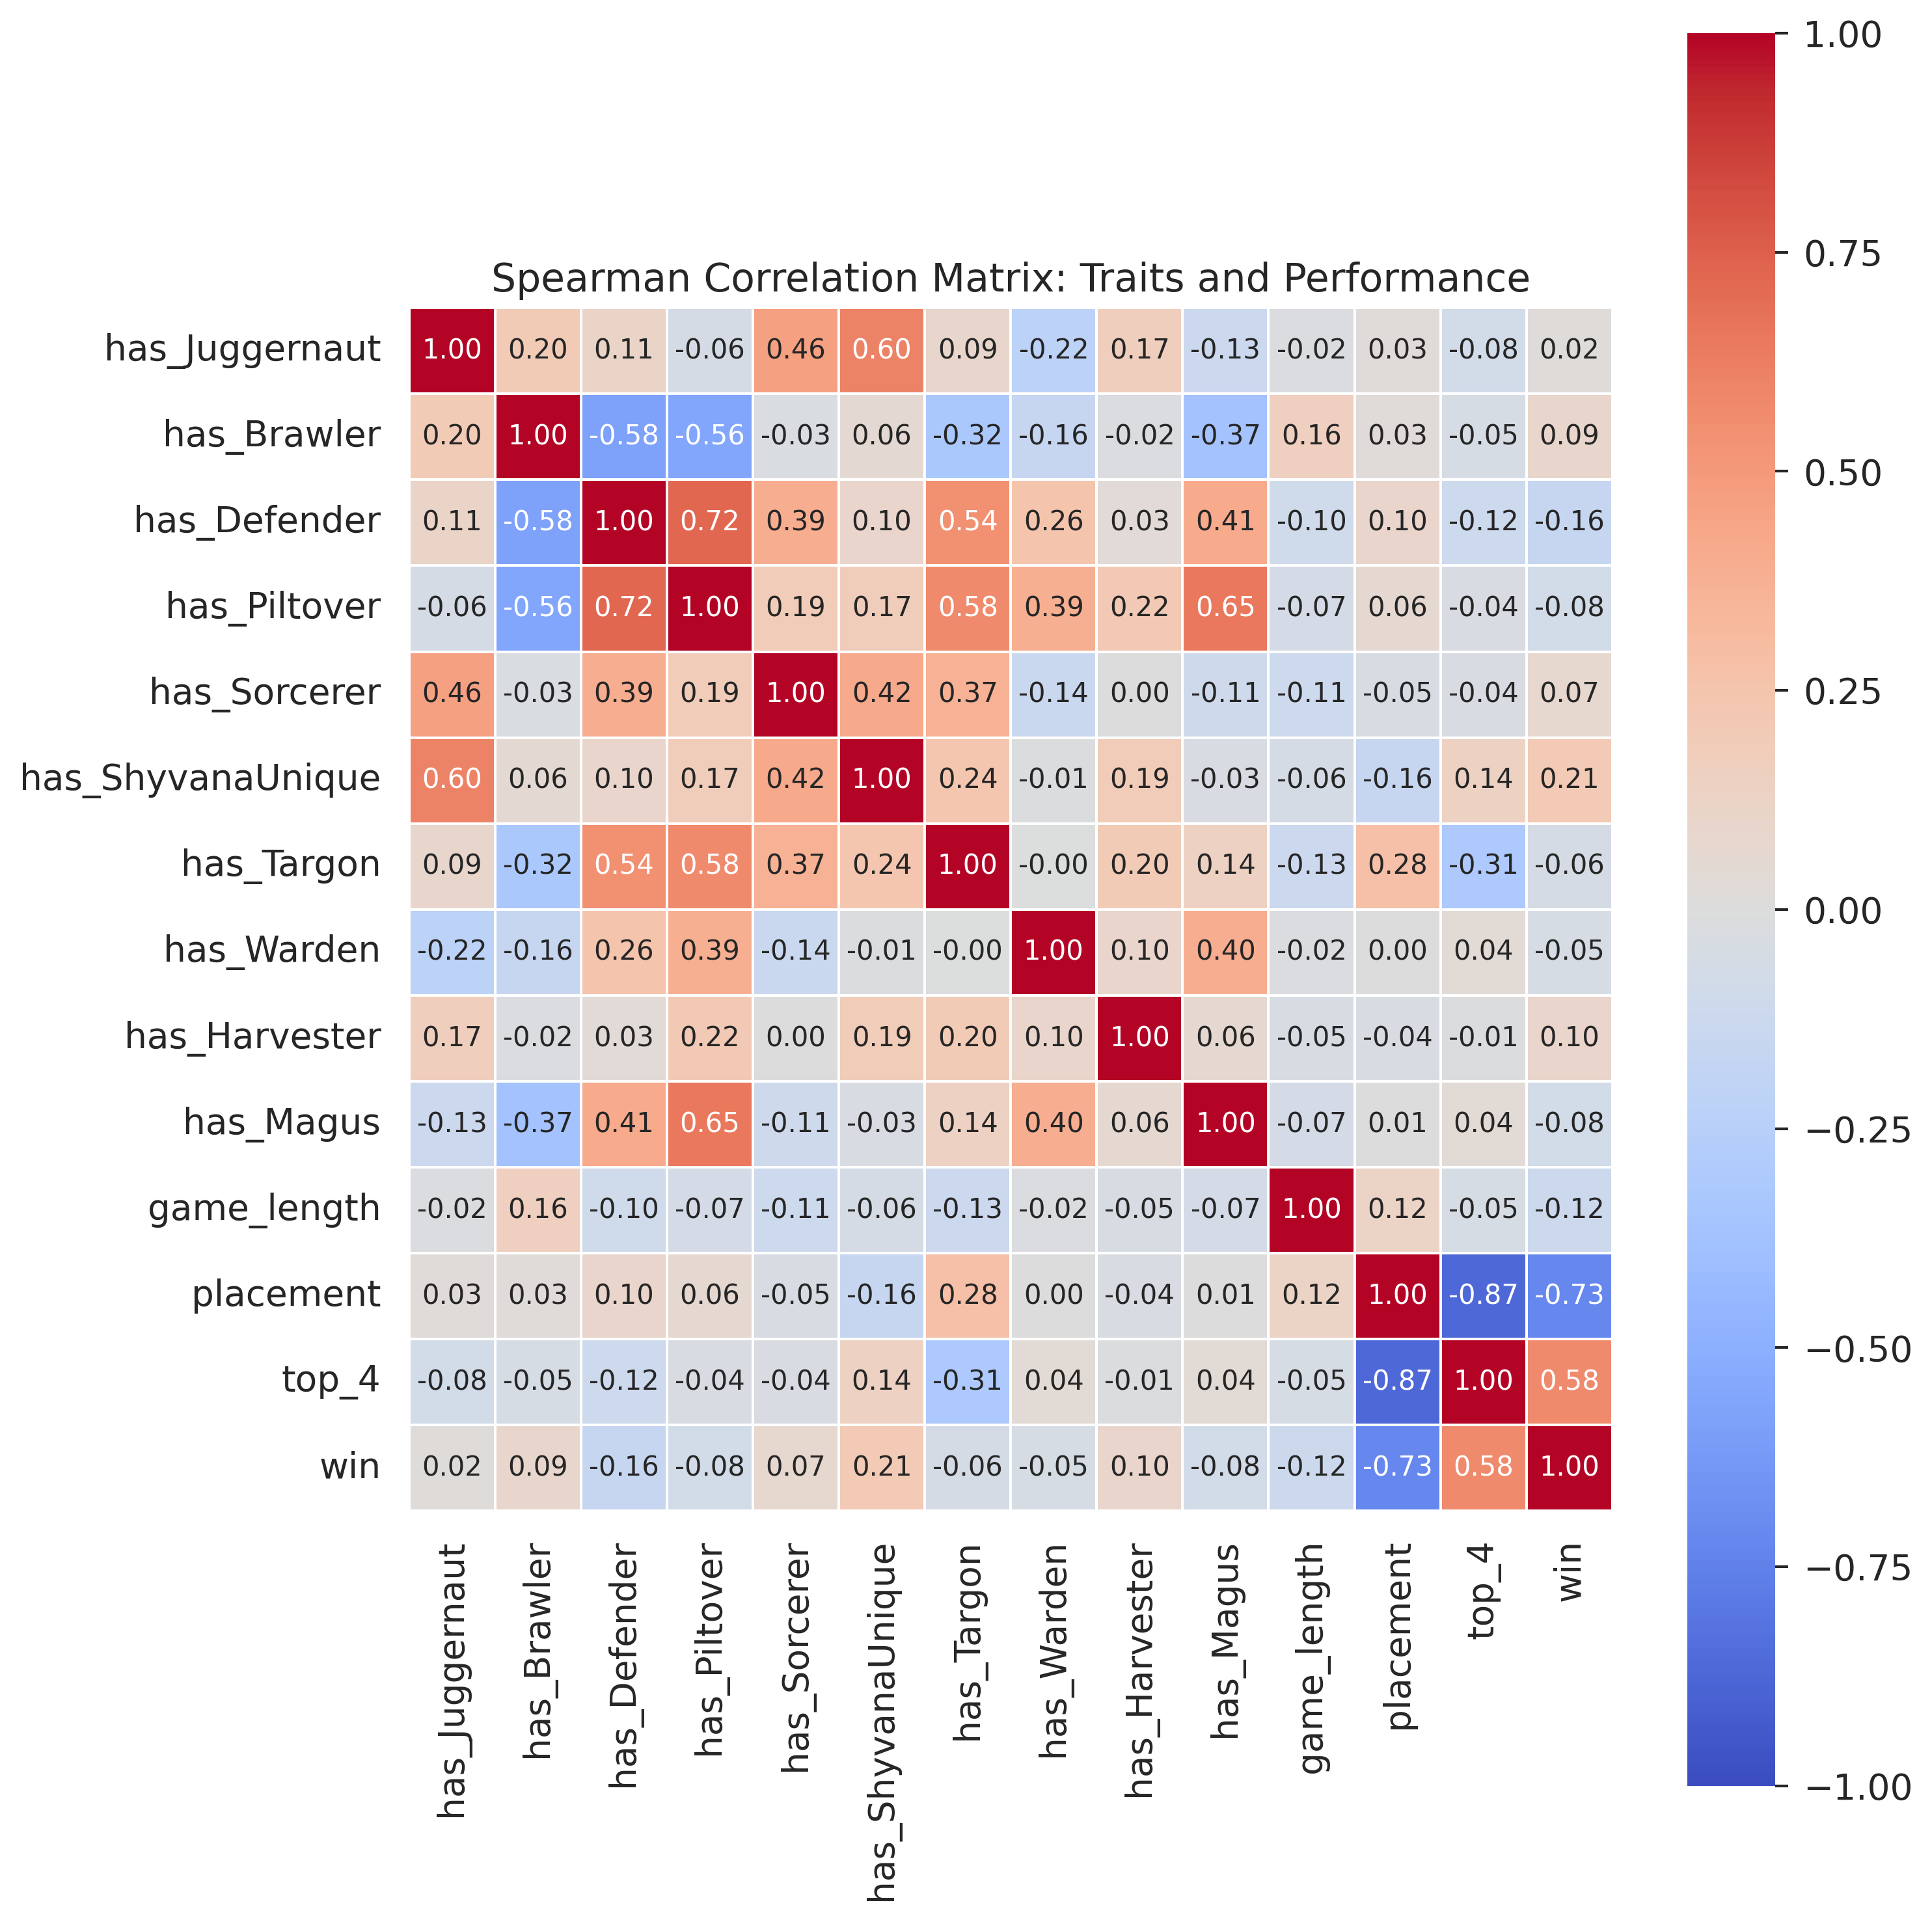

In [30]:
# Cell 5: Predictive Performance Indicators
print("="*60)
print("PREDICTIVE PERFORMANCE INDICATORS")
print("="*60)

# Create feature matrix for correlation analysis
feature_matrix = pd.DataFrame()

# Add trait presence features
for trait in top_10_traits:
    feature_matrix[f'has_{trait}'] = your_games['trait_list'].apply(
        lambda x: 1 if trait in x else 0)

# Add game metadata if available
if 'game_length' in your_games.columns:
    feature_matrix['game_length'] = your_games['game_length']

# Add performance metrics
feature_matrix['placement'] = your_games['placement']
feature_matrix['top_4'] = your_games['top_4']
feature_matrix['win'] = your_games['win']

# Calculate Spearman correlation (better for non-linear relationships)
correlation_matrix = feature_matrix.corr(method='spearman')

# Focus on correlations with placement
placement_correlations = correlation_matrix['placement'].sort_values()
print("\nFeatures Most Correlated with Better Placement (Lower = Better):")
print(placement_correlations.head(10))

print("\nFeatures Most Correlated with Worse Placement:")
print(placement_correlations.tail(10))

# Visualize key correlations
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix: Traits and Performance')
plt.tight_layout()
plt.savefig('correlation_matrix_detailed.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: correlation_matrix_detailed.png")

# Statistical significance testing
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

# Test each top trait for significant impact on placement
significant_traits = []
for trait in top_10_traits:
    with_trait = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    without_trait = your_games[your_games['trait_list'].apply(lambda x: trait not in x)]

    if len(with_trait) >= 5 and len(without_trait) >= 5:
        # Use Mann-Whitney U test (non-parametric)
        statistic, p_value = mannwhitneyu(with_trait['placement'],
                                          without_trait['placement'],
                                          alternative='two-sided')

        effect_size = (with_trait['placement'].mean() -
                      without_trait['placement'].mean())

        significant_traits.append({
            'Trait': trait,
            'With (n)': len(with_trait),
            'Without (n)': len(without_trait),
            'Avg With': with_trait['placement'].mean(),
            'Avg Without': without_trait['placement'].mean(),
            'Effect': effect_size,
            'P-value': p_value,
            'Significant': '✓' if p_value < 0.05 else '✗'
        })

sig_df = pd.DataFrame(significant_traits).sort_values('P-value')
print("\nTrait Impact Significance Tests:")
print(sig_df.to_string(index=False))

# Count significant traits
sig_count = sig_df[sig_df['Significant'] == '✓'].shape[0]
print(f"\n{sig_count}/{len(top_10_traits)} traits show statistically significant impact (p < 0.05)")

GENERATING COMPREHENSIVE PERFORMANCE DASHBOARD

✅ Saved: performance_dashboard.png


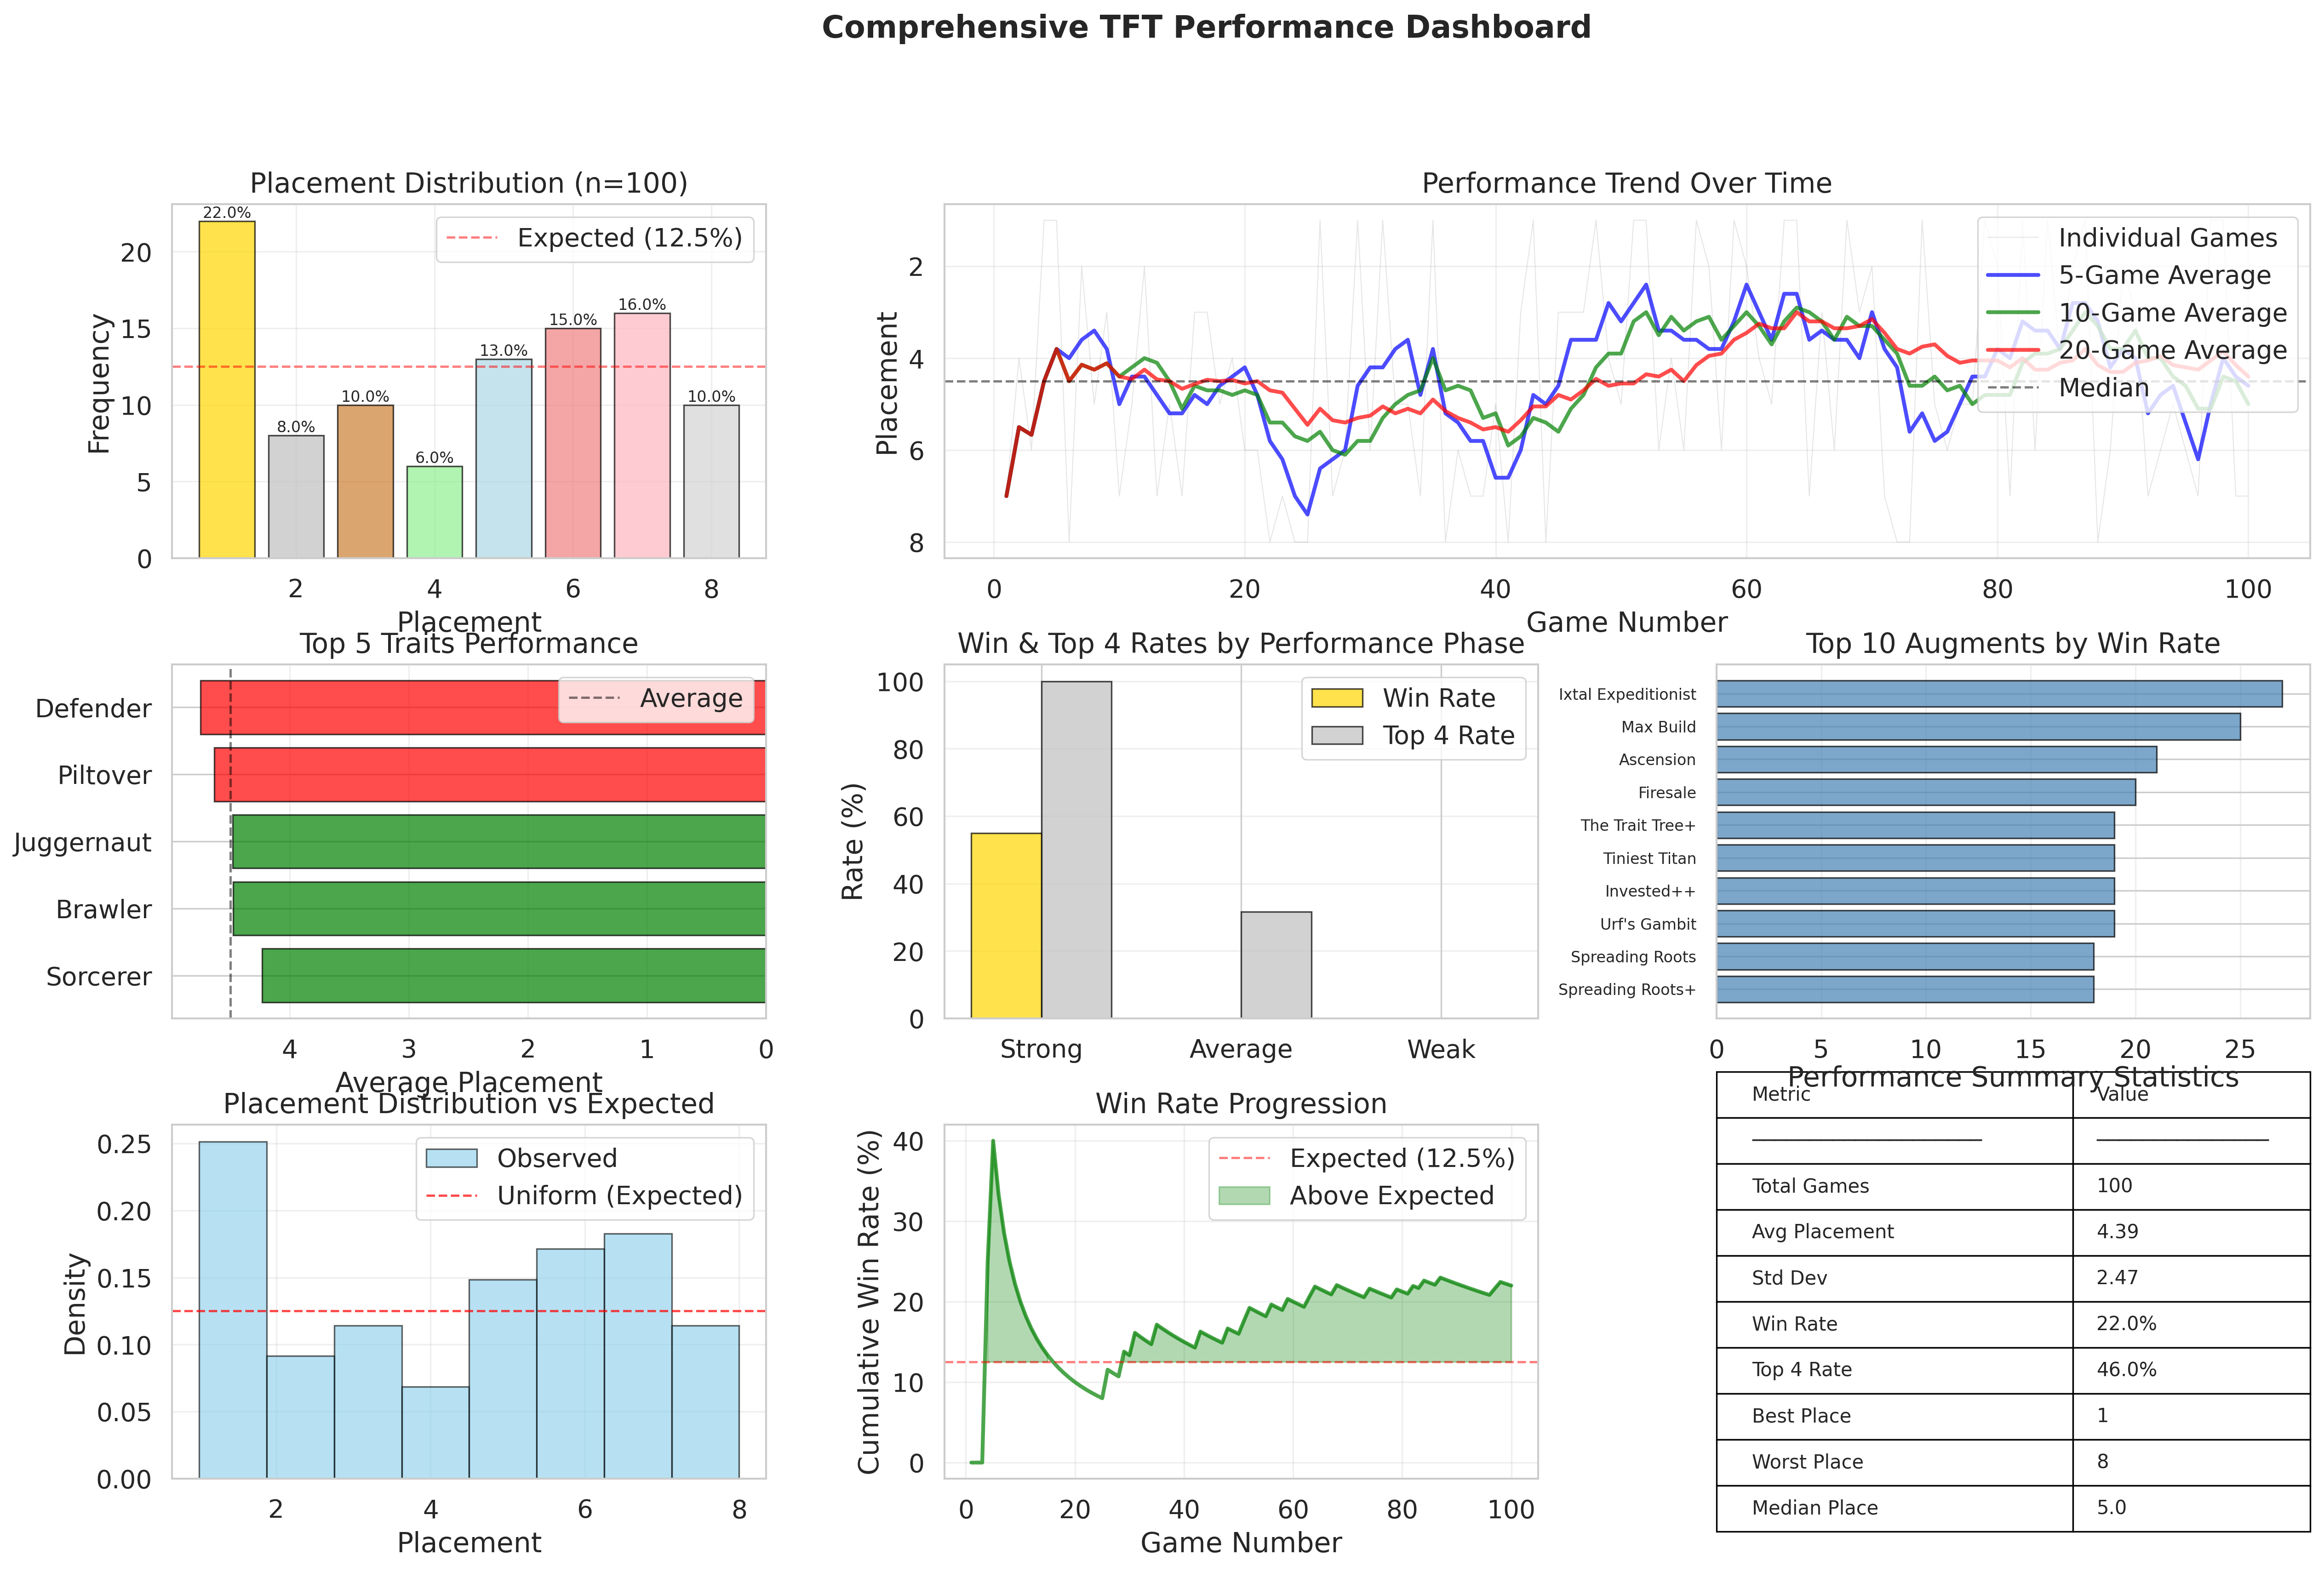

In [31]:
# Cell 6: Advanced Visualization - Performance Dashboard
print("="*60)
print("GENERATING COMPREHENSIVE PERFORMANCE DASHBOARD")
print("="*60)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Placement distribution with statistics
ax1 = fig.add_subplot(gs[0, 0])
placement_counts = your_games['placement'].value_counts().sort_index()
colors = ['gold', 'silver', '#CD7F32', 'lightgreen',
          'lightblue', 'lightcoral', 'lightpink', 'lightgray']
bars = ax1.bar(placement_counts.index, placement_counts.values,
               color=colors[:len(placement_counts)], edgecolor='black', alpha=0.7)
ax1.axhline(len(your_games)/8, color='red', linestyle='--',
            alpha=0.5, label='Expected (12.5%)')
ax1.set_xlabel('Placement')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Placement Distribution (n={len(your_games)})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/len(your_games)*100:.1f}%',
            ha='center', va='bottom', fontsize=8)

# 2. Performance trend with multiple windows
ax2 = fig.add_subplot(gs[0, 1:])
ax2.plot(your_games['game_number'], your_games['placement'],
         alpha=0.2, color='gray', label='Individual Games', linewidth=0.5)
colors_rolling = ['blue', 'green', 'red']
for i, window in enumerate([5, 10, 20]):
    ax2.plot(your_games['game_number'],
            your_games[f'rolling_avg_{window}'],
            linewidth=2, color=colors_rolling[i],
            label=f'{window}-Game Average', alpha=0.7)
ax2.axhline(4.5, color='black', linestyle='--', alpha=0.5, label='Median')
ax2.set_xlabel('Game Number')
ax2.set_ylabel('Placement')
ax2.set_title('Performance Trend Over Time')
ax2.legend(loc='upper right')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

# 3. Trait performance comparison
ax3 = fig.add_subplot(gs[1, 0])
trait_perf = []
for trait in top_10_traits[:5]:  # Top 5 for clarity
    games_w_trait = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    trait_perf.append({
        'trait': trait[:15],  # Truncate long names
        'avg': games_w_trait['placement'].mean(),
        'count': len(games_w_trait)
    })
trait_perf_df = pd.DataFrame(trait_perf).sort_values('avg')
colors_perf = ['green' if x < 4.5 else 'red' for x in trait_perf_df['avg']]
ax3.barh(trait_perf_df['trait'], trait_perf_df['avg'],
         color=colors_perf, edgecolor='black', alpha=0.7)
ax3.axvline(4.5, color='black', linestyle='--', alpha=0.5, label='Average')
ax3.set_xlabel('Average Placement')
ax3.set_title('Top 5 Traits Performance')
ax3.invert_xaxis()
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Win rate by placement phase
ax4 = fig.add_subplot(gs[1, 1])
phase_stats = your_games.groupby('performance_phase').agg({
    'win': 'mean',
    'top_4': 'mean',
    'placement': 'count'
}).reset_index()
phase_stats = phase_stats.sort_values('win', ascending=False)
x = range(len(phase_stats))
width = 0.35
ax4.bar([i - width/2 for i in x], phase_stats['win']*100,
        width, label='Win Rate', color='gold', edgecolor='black', alpha=0.7)
ax4.bar([i + width/2 for i in x], phase_stats['top_4']*100,
        width, label='Top 4 Rate', color='silver', edgecolor='black', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels(phase_stats['performance_phase'])
ax4.set_ylabel('Rate (%)')
ax4.set_title('Win & Top 4 Rates by Performance Phase')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Augment effectiveness (if data available)
ax5 = fig.add_subplot(gs[1, 2])
top_aug_perf = top_augments.head(10).sort_values('Win Rate', ascending=True)
ax5.barh(range(len(top_aug_perf)), top_aug_perf['Win Rate']*100,
         color='steelblue', edgecolor='black', alpha=0.7)
ax5.set_yticks(range(len(top_aug_perf)))
ax5.set_yticklabels([name[:20] for name in top_aug_perf['Augment Name']],
                     fontsize=8)
ax5.set_xlabel('Win Rate (%)')
ax5.set_title('Top 10 Augments by Win Rate')
ax5.grid(True, alpha=0.3, axis='x')

# 6. Performance distribution comparison
ax6 = fig.add_subplot(gs[2, 0])
ax6.hist(your_games['placement'], bins=8, edgecolor='black',
         alpha=0.6, color='skyblue', density=True, label='Observed')
# Add theoretical uniform distribution
ax6.axhline(1/8, color='red', linestyle='--', alpha=0.7,
            label='Uniform (Expected)')
ax6.set_xlabel('Placement')
ax6.set_ylabel('Density')
ax6.set_title('Placement Distribution vs Expected')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Cumulative win rate
ax7 = fig.add_subplot(gs[2, 1])
cumulative_wins = your_games['win'].cumsum()
cumulative_games = range(1, len(your_games) + 1)
cumulative_winrate = [cumulative_wins.iloc[i]/cumulative_games[i]*100
                      for i in range(len(cumulative_games))]
ax7.plot(cumulative_games, cumulative_winrate,
         linewidth=2, color='green', alpha=0.7)
ax7.axhline(12.5, color='red', linestyle='--', alpha=0.5,
            label='Expected (12.5%)')
ax7.fill_between(cumulative_games, cumulative_winrate, 12.5,
                 where=np.array(cumulative_winrate) > 12.5,
                 alpha=0.3, color='green', label='Above Expected')
ax7.set_xlabel('Game Number')
ax7.set_ylabel('Cumulative Win Rate (%)')
ax7.set_title('Win Rate Progression')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Statistical summary table
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
summary_stats_display = [
    ['Metric', 'Value'],
    ['─'*20, '─'*15],
    ['Total Games', f'{len(your_games)}'],
    ['Avg Placement', f'{your_games["placement"].mean():.2f}'],
    ['Std Dev', f'{your_games["placement"].std():.2f}'],
    ['Win Rate', f'{your_games["win"].mean()*100:.1f}%'],
    ['Top 4 Rate', f'{your_games["top_4"].mean()*100:.1f}%'],
    ['Best Place', f'{your_games["placement"].min():.0f}'],
    ['Worst Place', f'{your_games["placement"].max():.0f}'],
    ['Median Place', f'{your_games["placement"].median():.1f}'],
]
table = ax8.table(cellText=summary_stats_display, loc='center',
                 cellLoc='left', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax8.set_title('Performance Summary Statistics', pad=20)

plt.suptitle('Comprehensive TFT Performance Dashboard',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: performance_dashboard.png")

In [32]:
# Cell 7: Export Results for IEEE Paper Tables
print("="*60)
print("EXPORTING DATA FOR IEEE PAPER")
print("="*60)

# Table 1: Overall Performance Summary
overall_summary = pd.DataFrame({
    'Metric': [
        'Total Games Analyzed',
        'Average Placement',
        'Standard Deviation',
        'Win Rate (%)',
        'Top 4 Rate (%)',
        'Top 1-3 Rate (%)',
        'Bottom 4 Rate (%)',
        'Best Placement',
        'Worst Placement',
        'Median Placement'
    ],
    'Value': [
        len(your_games),
        f'{your_games["placement"].mean():.3f}',
        f'{your_games["placement"].std():.3f}',
        f'{your_games["win"].mean()*100:.2f}',
        f'{your_games["top_4"].mean()*100:.2f}',
        f'{(your_games["placement"] <= 3).mean()*100:.2f}',
        f'{(your_games["placement"] > 4).mean()*100:.2f}',
        your_games["placement"].min(),
        your_games["placement"].max(),
        f'{your_games["placement"].median():.1f}'
    ]
})
overall_summary.to_csv('table1_overall_summary.csv', index=False)
print("✅ Exported: table1_overall_summary.csv")
print(overall_summary.to_string(index=False))

# Table 2: Trait Performance Analysis
trait_performance = []
for trait in top_10_traits:
    games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    games_without = your_games[your_games['trait_list'].apply(lambda x: trait not in x)]

    if len(games_with) >= 3:
        # Mann-Whitney U test
        _, p_value = mannwhitneyu(games_with['placement'],
                                  games_without['placement'],
                                  alternative='two-sided')

        trait_performance.append({
            'Trait': trait,
            'Games Played': len(games_with),
            'Usage Rate (%)': f'{len(games_with)/len(your_games)*100:.1f}',
            'Avg Placement': f'{games_with["placement"].mean():.3f}',
            'Win Rate (%)': f'{games_with["win"].mean()*100:.2f}',
            'Top 4 Rate (%)': f'{games_with["top_4"].mean()*100:.2f}',
            'Std Dev': f'{games_with["placement"].std():.3f}',
            'P-value': f'{p_value:.4f}',
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

trait_perf_df = pd.DataFrame(trait_performance).sort_values('Avg Placement')
trait_perf_df.to_csv('table2_trait_performance.csv', index=False)
print("\n✅ Exported: table2_trait_performance.csv")
print("\nTable 2: Trait Performance Analysis")
print(trait_perf_df.to_string(index=False))

# Table 3: Top Augment Analysis
augment_analysis = top_augments.head(10)[['Augment Name', 'Win Rate',
                                           'Average Placement', 'Top 4',
                                           'Games Played']].copy()
augment_analysis['Win Rate'] = augment_analysis['Win Rate'].apply(lambda x: f'{x*100:.2f}')
augment_analysis['Top 4'] = augment_analysis['Top 4'].apply(lambda x: f'{x*100:.2f}')
augment_analysis.columns = ['Augment', 'Win Rate (%)', 'Avg Placement',
                           'Top 4 Rate (%)', 'Games Played']
augment_analysis.to_csv('table3_top_augments.csv', index=False)
print("\n✅ Exported: table3_top_augments.csv")
print("\nTable 3: Top Augment Performance")
print(augment_analysis.to_string(index=False))

# Table 4: Performance Phase Analysis
phase_analysis = your_games.groupby('performance_phase').agg({
    'placement': ['count', 'mean', 'std'],
    'win': ['sum', 'mean'],
    'top_4': ['sum', 'mean']
}).round(3)
phase_analysis.columns = ['Games', 'Avg Place', 'Std Dev',
                         'Wins', 'Win Rate', 'Top 4s', 'Top 4 Rate']
phase_analysis['Win Rate'] = phase_analysis['Win Rate'] * 100
phase_analysis['Top 4 Rate'] = phase_analysis['Top 4 Rate'] * 100
phase_analysis = phase_analysis.sort_values('Avg Place')
phase_analysis.to_csv('table4_phase_analysis.csv')
print("\n✅ Exported: table4_phase_analysis.csv")
print("\nTable 4: Performance Phase Analysis")
print(phase_analysis)

# Table 5: Statistical Significance Results
sig_results = sig_df[['Trait', 'With (n)', 'Avg With', 'Avg Without',
                      'Effect', 'P-value', 'Significant']].copy()
sig_results.columns = ['Trait', 'Sample Size', 'Avg Placement (With)',
                      'Avg Placement (Without)', 'Effect Size',
                      'P-value', 'Significant (α=0.05)']
sig_results.to_csv('table5_significance_tests.csv', index=False)
print("\n✅ Exported: table5_significance_tests.csv")
print("\nTable 5: Statistical Significance Tests")
print(sig_results.to_string(index=False))

print("\n" + "="*60)
print("ALL TABLES EXPORTED FOR IEEE PAPER")
print("="*60)

EXPORTING DATA FOR IEEE PAPER
✅ Exported: table1_overall_summary.csv
              Metric Value
Total Games Analyzed   100
   Average Placement 4.390
  Standard Deviation 2.465
        Win Rate (%) 22.00
      Top 4 Rate (%) 46.00
    Top 1-3 Rate (%) 40.00
   Bottom 4 Rate (%) 54.00
      Best Placement     1
     Worst Placement     8
    Median Placement   5.0

✅ Exported: table2_trait_performance.csv

Table 2: Trait Performance Analysis
        Trait  Games Played Usage Rate (%) Avg Placement Win Rate (%) Top 4 Rate (%) Std Dev P-value Significant
ShyvanaUnique            28           28.0         3.786        35.71          57.14   2.529  0.1158          No
     Sorcerer            30           30.0         4.233        26.67          43.33   2.542  0.6452          No
    Harvester            20           20.0         4.250        30.00          45.00   2.531  0.7240          No
       Warden            22           22.0         4.364        18.18          50.00   2.479  1.0000   

In [33]:
# Cell 8: Generate LaTeX Tables for Direct IEEE Paper Integration
print("="*60)
print("GENERATING LATEX TABLES FOR IEEE PAPER")
print("="*60)

def df_to_latex_ieee(df, caption, label, float_format='%.2f'):
    """Convert DataFrame to IEEE-style LaTeX table"""
    latex = df.to_latex(index=False, float_format=float_format,
                        caption=caption, label=label,
                        position='htbp', column_format='l' + 'c'*(len(df.columns)-1))
    return latex

# Generate LaTeX for all tables
with open('ieee_latex_tables.tex', 'w') as f:
    f.write("% LaTeX Tables for IEEE Paper\n")
    f.write("% Copy and paste these into your IEEE paper\n\n")

    # Table 1
    f.write("% TABLE 1: Overall Performance Summary\n")
    f.write(df_to_latex_ieee(overall_summary,
                             'Overall TFT Performance Summary',
                             'tab:overall_summary'))
    f.write("\n\n")

    # Table 2
    f.write("% TABLE 2: Trait Performance Analysis\n")
    f.write(df_to_latex_ieee(trait_perf_df,
                             'Top 10 Trait Performance Analysis with Statistical Significance',
                             'tab:trait_performance'))
    f.write("\n\n")

    # Table 3
    f.write("% TABLE 3: Top Augments\n")
    f.write(df_to_latex_ieee(augment_analysis,
                             'Top 10 Augments by Win Rate (Minimum 100 Games)',
                             'tab:top_augments'))
    f.write("\n\n")

print("✅ Generated: ieee_latex_tables.tex")
print("\nLaTeX tables ready for copy-paste into IEEE paper!")

# Also generate a quick reference summary
print("\n" + "="*60)
print("QUICK REFERENCE SUMMARY FOR RESULTS SECTION")
print("="*60)
print(f"""
Key Findings for IEEE Paper:

1. DATASET CHARACTERISTICS:
   - Total games analyzed: {len(your_games)}
   - Average placement: {your_games['placement'].mean():.2f} (σ = {your_games['placement'].std():.2f})
   - Win rate: {your_games['win'].mean()*100:.1f}% (theoretical: 12.5%)
   - Top 4 rate: {your_games['top_4'].mean()*100:.1f}% (theoretical: 50%)

2. TRAIT ANALYSIS:
   - Most used trait: {trait_perf_df.iloc[0]['Trait']} ({trait_perf_df.iloc[0]['Games Played']} games)
   - Best performing trait: {trait_perf_df.iloc[0]['Trait']} (Avg: {trait_perf_df.iloc[0]['Avg Placement']})
   - Statistically significant traits: {sig_results[sig_results['Significant (α=0.05)'] == 'Yes'].shape[0]}/{len(top_10_traits)}

3. AUGMENT EFFECTIVENESS:
   - Top augment: {augment_analysis.iloc[0]['Augment']} (WR: {augment_analysis.iloc[0]['Win Rate (%)']}%)
   - Sample size range: {augment_analysis['Games Played'].min()}-{augment_analysis['Games Played'].max()} games

4. PERFORMANCE TRENDS:
   - Strong phase games: {phase_dist.get('Strong', 0)} ({phase_dist.get('Strong', 0)/len(your_games)*100:.1f}%)
   - Average phase games: {phase_dist.get('Average', 0)} ({phase_dist.get('Average', 0)/len(your_games)*100:.1f}%)
   - Weak phase games: {phase_dist.get('Weak', 0)} ({phase_dist.get('Weak', 0)/len(your_games)*100:.1f}%)

5. STATISTICAL RIGOR:
   - Confidence intervals calculated using Wilson score method
   - Non-parametric tests (Mann-Whitney U) used for placement comparisons
   - Spearman correlation for non-linear relationships
   - Significance threshold: α = 0.05
""")

GENERATING LATEX TABLES FOR IEEE PAPER
✅ Generated: ieee_latex_tables.tex

LaTeX tables ready for copy-paste into IEEE paper!

QUICK REFERENCE SUMMARY FOR RESULTS SECTION

Key Findings for IEEE Paper:

1. DATASET CHARACTERISTICS:
   - Total games analyzed: 100
   - Average placement: 4.39 (σ = 2.47)
   - Win rate: 22.0% (theoretical: 12.5%)
   - Top 4 rate: 46.0% (theoretical: 50%)

2. TRAIT ANALYSIS:
   - Most used trait: ShyvanaUnique (28 games)
   - Best performing trait: ShyvanaUnique (Avg: 3.786)
   - Statistically significant traits: 0/10

3. AUGMENT EFFECTIVENESS:
   - Top augment: Ixtal Expeditionist (WR: 27.00%)
   - Sample size range: 115-500 games

4. PERFORMANCE TRENDS:
   - Strong phase games: 40 (40.0%)
   - Average phase games: 19 (19.0%)
   - Weak phase games: 41 (41.0%)

5. STATISTICAL RIGOR:
   - Confidence intervals calculated using Wilson score method
   - Non-parametric tests (Mann-Whitney U) used for placement comparisons
   - Spearman correlation for non-linear r